# Load libraries

In [176]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

%matplotlib inline

# Load dataset

In [177]:
# Seed setter for reproducibility
def set_seed(seed_value=1901448):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True  # For GPU reproducibility
        torch.backends.cudnn.benchmark = False  # Ensures reproducibility but can make training slower

set_seed(1901448)

data_path = 'data/diabetes.txt'

X, y = load_svmlight_file(data_path)

X_dense = X.toarray()

# print("Features (X):")
# print(X_dense)

# print("\nOutcome (y):")
# print(y)

# Create a DataFrame with feature columns
df_features = pd.DataFrame(X_dense)
df_features.columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# Add the outcome (y) as a separate column in the DataFrame
diabetes_df = pd.concat([pd.Series(y, name='Outcome'), df_features], axis=1)

# Display the DataFrame
print(diabetes_df)

     Outcome  Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin  \
0       -1.0          6.0    148.0           72.0           35.0      0.0   
1        1.0          1.0     85.0           66.0           29.0      0.0   
2       -1.0          8.0    183.0           64.0            0.0      0.0   
3        1.0          1.0     89.0           66.0           23.0     94.0   
4       -1.0          0.0    137.0           40.0           35.0    168.0   
..       ...          ...      ...            ...            ...      ...   
763      1.0         10.0    101.0           76.0           48.0    180.0   
764      1.0          2.0    122.0           70.0           27.0      0.0   
765      1.0          5.0    121.0           72.0           23.0    112.0   
766     -1.0          1.0    126.0           60.0            0.0      0.0   
767      1.0          1.0     93.0           70.0           31.0      0.0   

           BMI  DiabetesPedigreeFunction   Age  
0    33.599998            

In [178]:
diabetes_df.info(verbose=True)

diabetes_df.describe().T



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Outcome                   768 non-null    float64
 1   Pregnancies               768 non-null    float64
 2   Glucose                   768 non-null    float64
 3   BloodPressure             768 non-null    float64
 4   SkinThickness             768 non-null    float64
 5   Insulin                   768 non-null    float64
 6   BMI                       768 non-null    float64
 7   DiabetesPedigreeFunction  768 non-null    float64
 8   Age                       768 non-null    float64
dtypes: float64(9)
memory usage: 54.1 KB


,count,mean,std,min,25%,50%,75%,max
Outcome,768.0,0.302083,0.953903,-1.000,-1.000000,1.0000,1.000000,1.000000
Pregnancies,768.0,3.845052,3.369578,0.000,1.000000,3.0000,6.000000,17.000000
Glucose,768.0,120.894531,31.972618,0.000,99.000000,117.0000,140.250000,199.000000
BloodPressure,768.0,69.105469,19.355807,0.000,62.000000,72.0000,80.000000,122.000000
SkinThickness,768.0,20.536458,15.952218,0.000,0.000000,23.0000,32.000000,99.000000
Insulin,768.0,79.799479,115.244002,0.000,0.000000,30.5000,127.250000,846.000000
BMI,768.0,31.992578,7.884160,0.000,27.299999,32.0000,36.599998,67.099998
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.243750,0.3725,0.626250,2.420000
Age,768.0,33.240885,11.760232,21.000,24.000000,29.0000,41.000000,81.000000


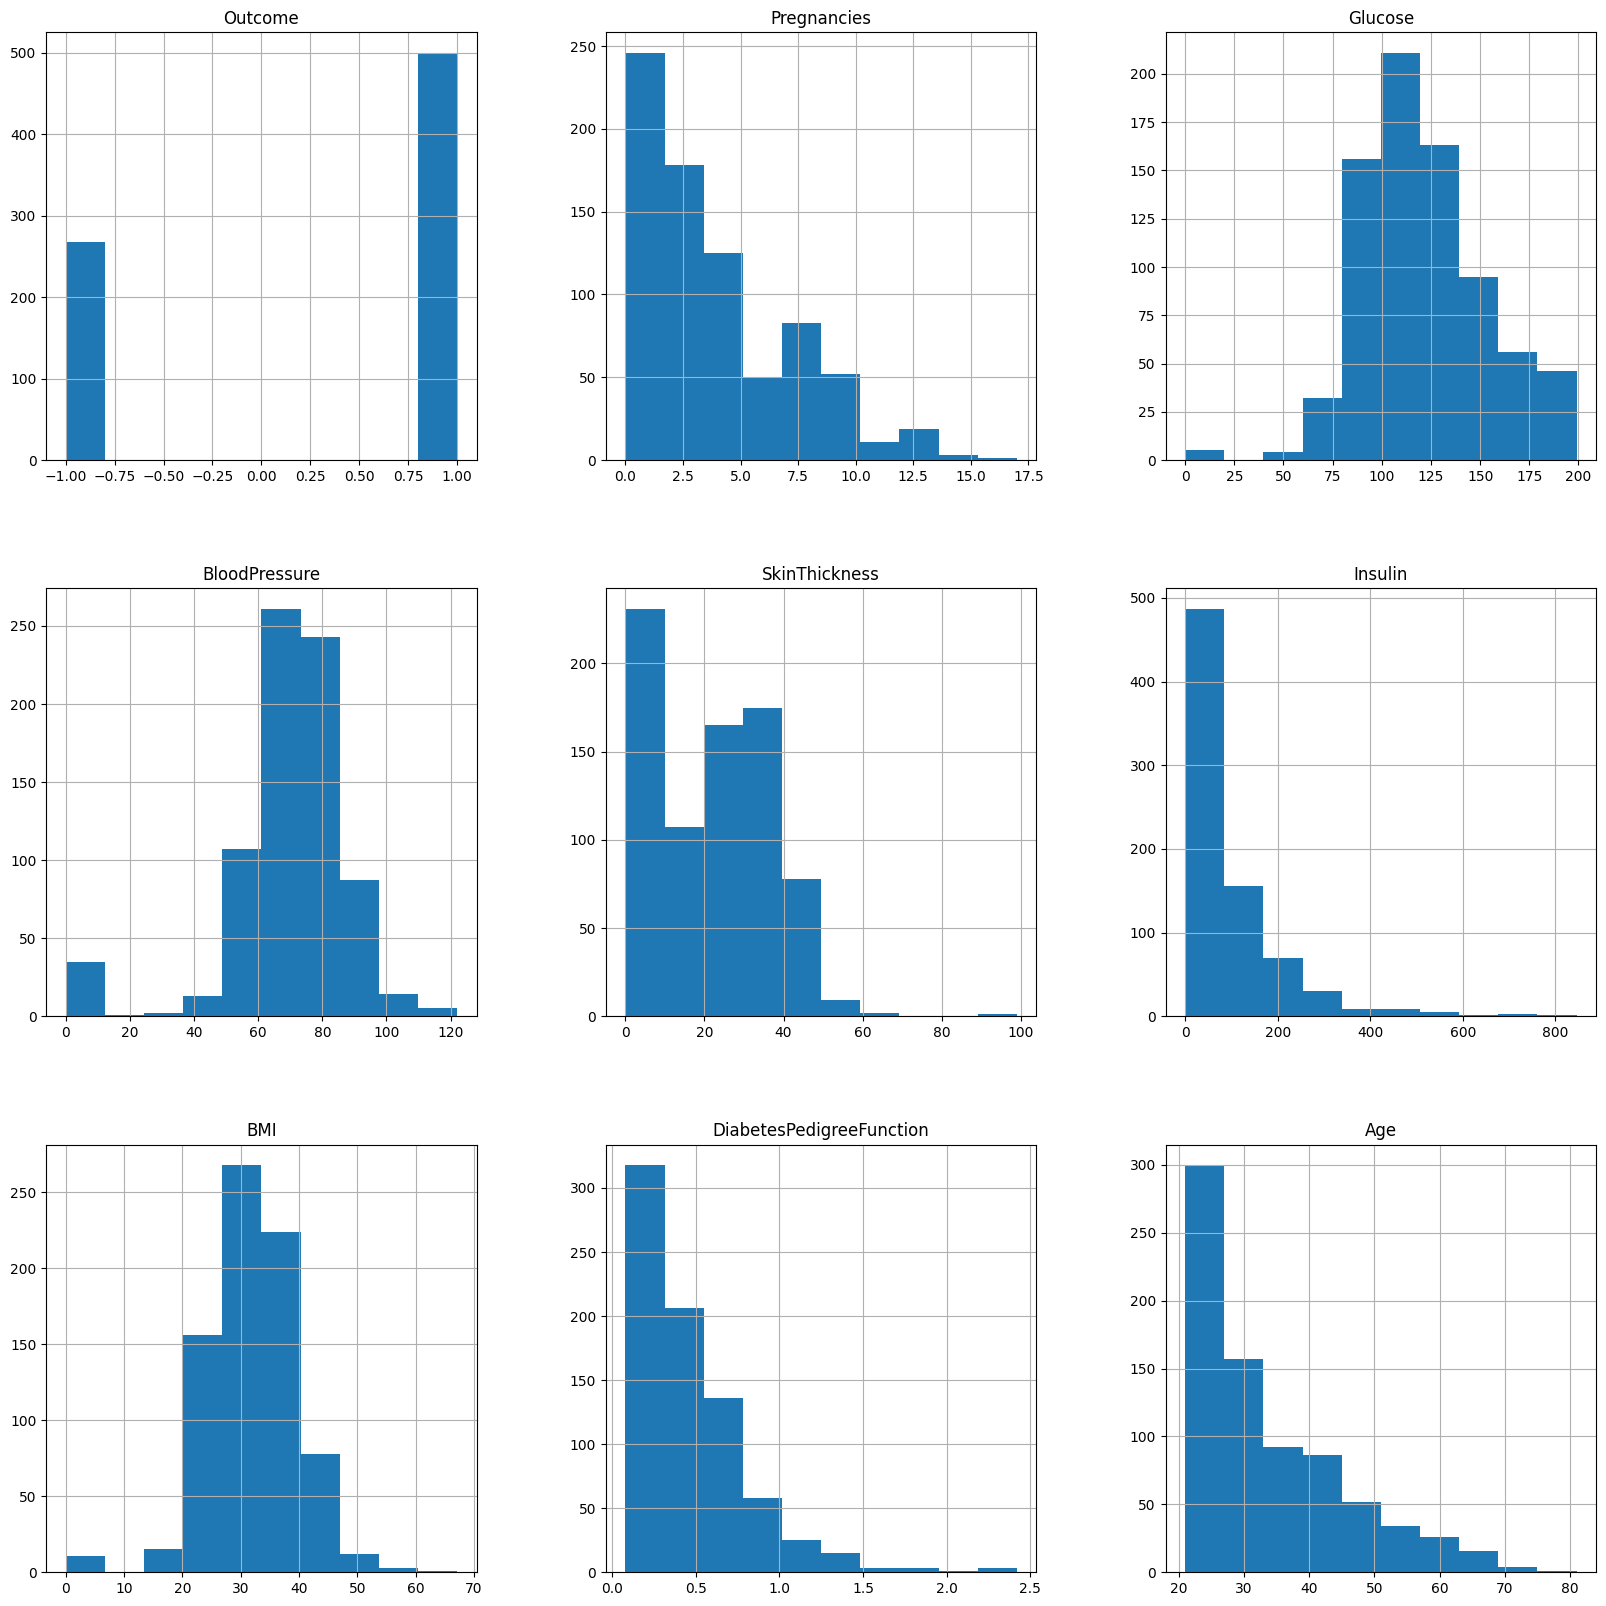

In [179]:
p = diabetes_df.hist(figsize = (20,20))

# Data scaling

In [180]:
sc_X = StandardScaler()
X =  pd.DataFrame(sc_X.fit_transform(diabetes_df.drop(["Outcome"],axis = 1),),
                  columns=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 
                           'BMI', 'DiabetesPedigreeFunction', 'Age'])

In [181]:
X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.639947,0.848324,0.149641,0.907270,-0.692891,0.204013,0.468492,1.425995
1,-0.844885,-1.123396,-0.160546,0.530902,-0.692891,-0.684422,-0.365061,-0.190672
2,1.233880,1.943724,-0.263941,-1.288212,-0.692891,-1.103256,0.604397,-0.105584
3,-0.844885,-0.998208,-0.160546,0.154533,0.123302,-0.494043,-0.920763,-1.041549
4,-1.141852,0.504055,-1.504687,0.907270,0.765836,1.409745,5.484909,-0.020496


# Train test split

In [182]:
y = diabetes_df.Outcome
# y = diabetes_df_cln.Outcome
X_train, X_test, y_train, y_test = train_test_split(X, diabetes_df['Outcome'], test_size = 1/3, 
                                                    random_state = 1901448, stratify= y)


# Build Perceptron model

In [183]:
y_train = (y_train == 1).astype(float)  # Convert -1 to 0 and keep 1 as 1
y_test = (y_test == 1).astype(float)

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Create a TensorDataset and DataLoader
def get_data_loader(X, y, batch_size=32):
    dataset = TensorDataset(X, y)
    return DataLoader(dataset=dataset, batch_size=32, shuffle=True)

train_dataloader = get_data_loader(X_train_tensor, y_train_tensor)
test_dataloader = get_data_loader(X_test_tensor, y_test_tensor)

# Split train and validation set

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_tensor, y_train_tensor, 
                                                                          test_size=1/5, random_state=1901448)
val_dataloader = get_data_loader(X_val_split, y_val_split)

# Single layer Perceptron model
class SingleLayerPerceptron(nn.Module):
    def __init__(self, input_dim):
        super(SingleLayerPerceptron, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x_in):
        out = self.fc1(x_in)
        out = self.sigmoid(out)
        return out

# Model training

In [184]:
def train_model(model, train_loader, val_loader, num_epochs, criterion, optimizer):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()

            # Calculate training accuracy
            predicted = (y_pred > 0.5).float()
            correct_train += (predicted == y_batch).sum().item()
            total_train += y_batch.size(0)

        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accuracies.append(correct_train / total_train * 100)

        # Validation phase using evaluate_model
        val_accuracy, avg_val_loss, _ = evaluate_model(model, val_loader, criterion)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, '
              f'Train Acc: {train_accuracies[-1]:.2f}%, Val Acc: {val_accuracy:.2f}%')

    return model, train_losses, val_losses, train_accuracies, val_accuracies

def evaluate_model(model, data_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            running_loss += loss.item()

            # For classification accuracy
            predicted = (outputs > 0.5).float()
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

            # Collect all predictions and labels for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    avg_loss = running_loss / len(data_loader)
    accuracy = correct / total * 100 if total > 0 else 0

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    return accuracy, avg_loss, cm

# Model, loss function and optimizer
input_dim = X_train.shape[1]
model = SingleLayerPerceptron(input_dim)
criterion = nn.BCELoss() # Binary Cross Entropy Loss function because our output is binary
optimizer = optim.SGD(model.parameters(), lr=0.01) # Stochastic Gradient Descent with learning rate 0.01

num_epochs = 50

set_seed(1901448)
model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_dataloader, val_dataloader, num_epochs, criterion, optimizer
)



Epoch 1/50, Train Loss: 0.7017, Val Loss: 0.7016, Train Acc: 52.73%, Val Acc: 58.25%
Epoch 2/50, Train Loss: 0.6820, Val Loss: 0.6586, Train Acc: 56.64%, Val Acc: 62.14%
Epoch 3/50, Train Loss: 0.6646, Val Loss: 0.6379, Train Acc: 61.72%, Val Acc: 66.02%
Epoch 4/50, Train Loss: 0.6491, Val Loss: 0.6399, Train Acc: 65.62%, Val Acc: 66.99%
Epoch 5/50, Train Loss: 0.6355, Val Loss: 0.6089, Train Acc: 68.55%, Val Acc: 67.96%
Epoch 6/50, Train Loss: 0.6233, Val Loss: 0.6188, Train Acc: 70.51%, Val Acc: 69.90%
Epoch 7/50, Train Loss: 0.6125, Val Loss: 0.6042, Train Acc: 71.88%, Val Acc: 71.84%
Epoch 8/50, Train Loss: 0.6027, Val Loss: 0.5887, Train Acc: 73.05%, Val Acc: 73.79%
Epoch 9/50, Train Loss: 0.5940, Val Loss: 0.5692, Train Acc: 74.22%, Val Acc: 75.73%
Epoch 10/50, Train Loss: 0.5860, Val Loss: 0.5491, Train Acc: 75.39%, Val Acc: 74.76%
Epoch 11/50, Train Loss: 0.5789, Val Loss: 0.5736, Train Acc: 75.59%, Val Acc: 74.76%
Epoch 12/50, Train Loss: 0.5725, Val Loss: 0.5542, Train Acc: 7

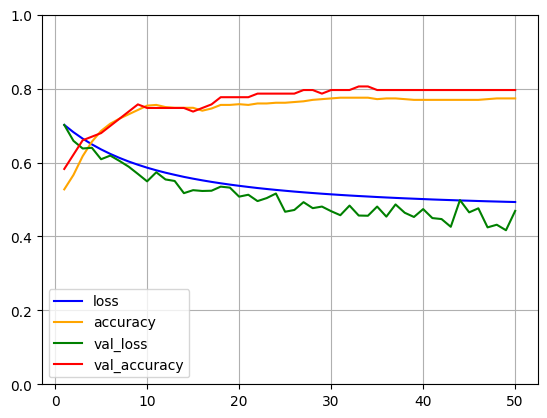

In [201]:
train_accuracies_rescaled = [acc / 100 for acc in train_accuracies]
val_accuracies_rescaled = [acc / 100 for acc in val_accuracies]

# Plot learning curves
plt.plot(range(1, num_epochs+1), train_losses, label='loss', color='blue')  # Blue
plt.plot(range(1, num_epochs+1), train_accuracies_rescaled, label='accuracy', color='orange')  # Orange
plt.plot(range(1, num_epochs+1), val_losses, label='val_loss', color='green')  # Green
plt.plot(range(1, num_epochs+1), val_accuracies_rescaled, label='val_accuracy', color='red')  # Red
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.legend()
plt.show()

# Model evaluation

Accuracy: 78.52%
Test Loss: 0.4891


<Axes: >

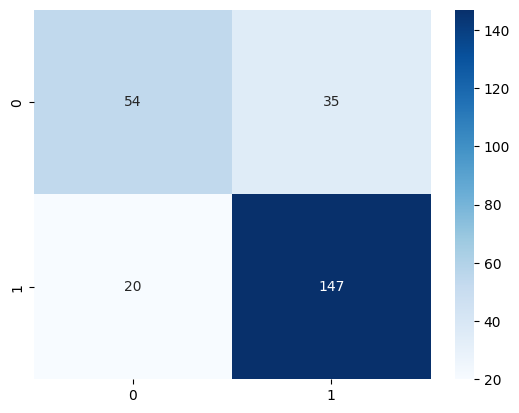

In [199]:
# Evaluate the model on the test set
accuracy, test_loss, cm = evaluate_model(model, test_dataloader, criterion)
print(f'Accuracy: {accuracy:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')


# Data imputation

Following columns should not have zero value:

1. Glucose
2. BloodPressure
3. SkinThickness
4. Insulin
5. BMI

So we replace them with NaN

In [193]:
diabetes_df_cln = diabetes_df.copy(deep=True)

diabetes_df_cln[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = diabetes_df_cln[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

There is also an outlier in skin thickness, we turn it into NaN as well

In [194]:
# Print the 3 highest values for each specified variable
variables = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

for var in variables:
    top_3_values = diabetes_df[var].nlargest(3)
    print(f"Top 3 values for {var}:")
    print(top_3_values.values)
    print()

# Replace the highest SkinThickness value (90) with NaN
diabetes_df_cln.loc[diabetes_df_cln['SkinThickness'] > 90, 'SkinThickness'] = np.nan
    
print(diabetes_df_cln.isnull().sum())

Top 3 values for Glucose:
[199. 198. 197.]

Top 3 values for BloodPressure:
[122. 114. 110.]

Top 3 values for SkinThickness:
[99. 63. 60.]

Top 3 values for Insulin:
[846. 744. 680.]

Top 3 values for BMI:
[67.099998 59.400002 57.299999]

Outcome                       0
Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               228
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
dtype: int64


Outcome                     0
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
dtype: int64


array([[<Axes: title={'center': 'Glucose'}>,
        <Axes: title={'center': 'BloodPressure'}>],
       [<Axes: title={'center': 'SkinThickness'}>,
        <Axes: title={'center': 'Insulin'}>],
       [<Axes: title={'center': 'BMI'}>, <Axes: >]], dtype=object)

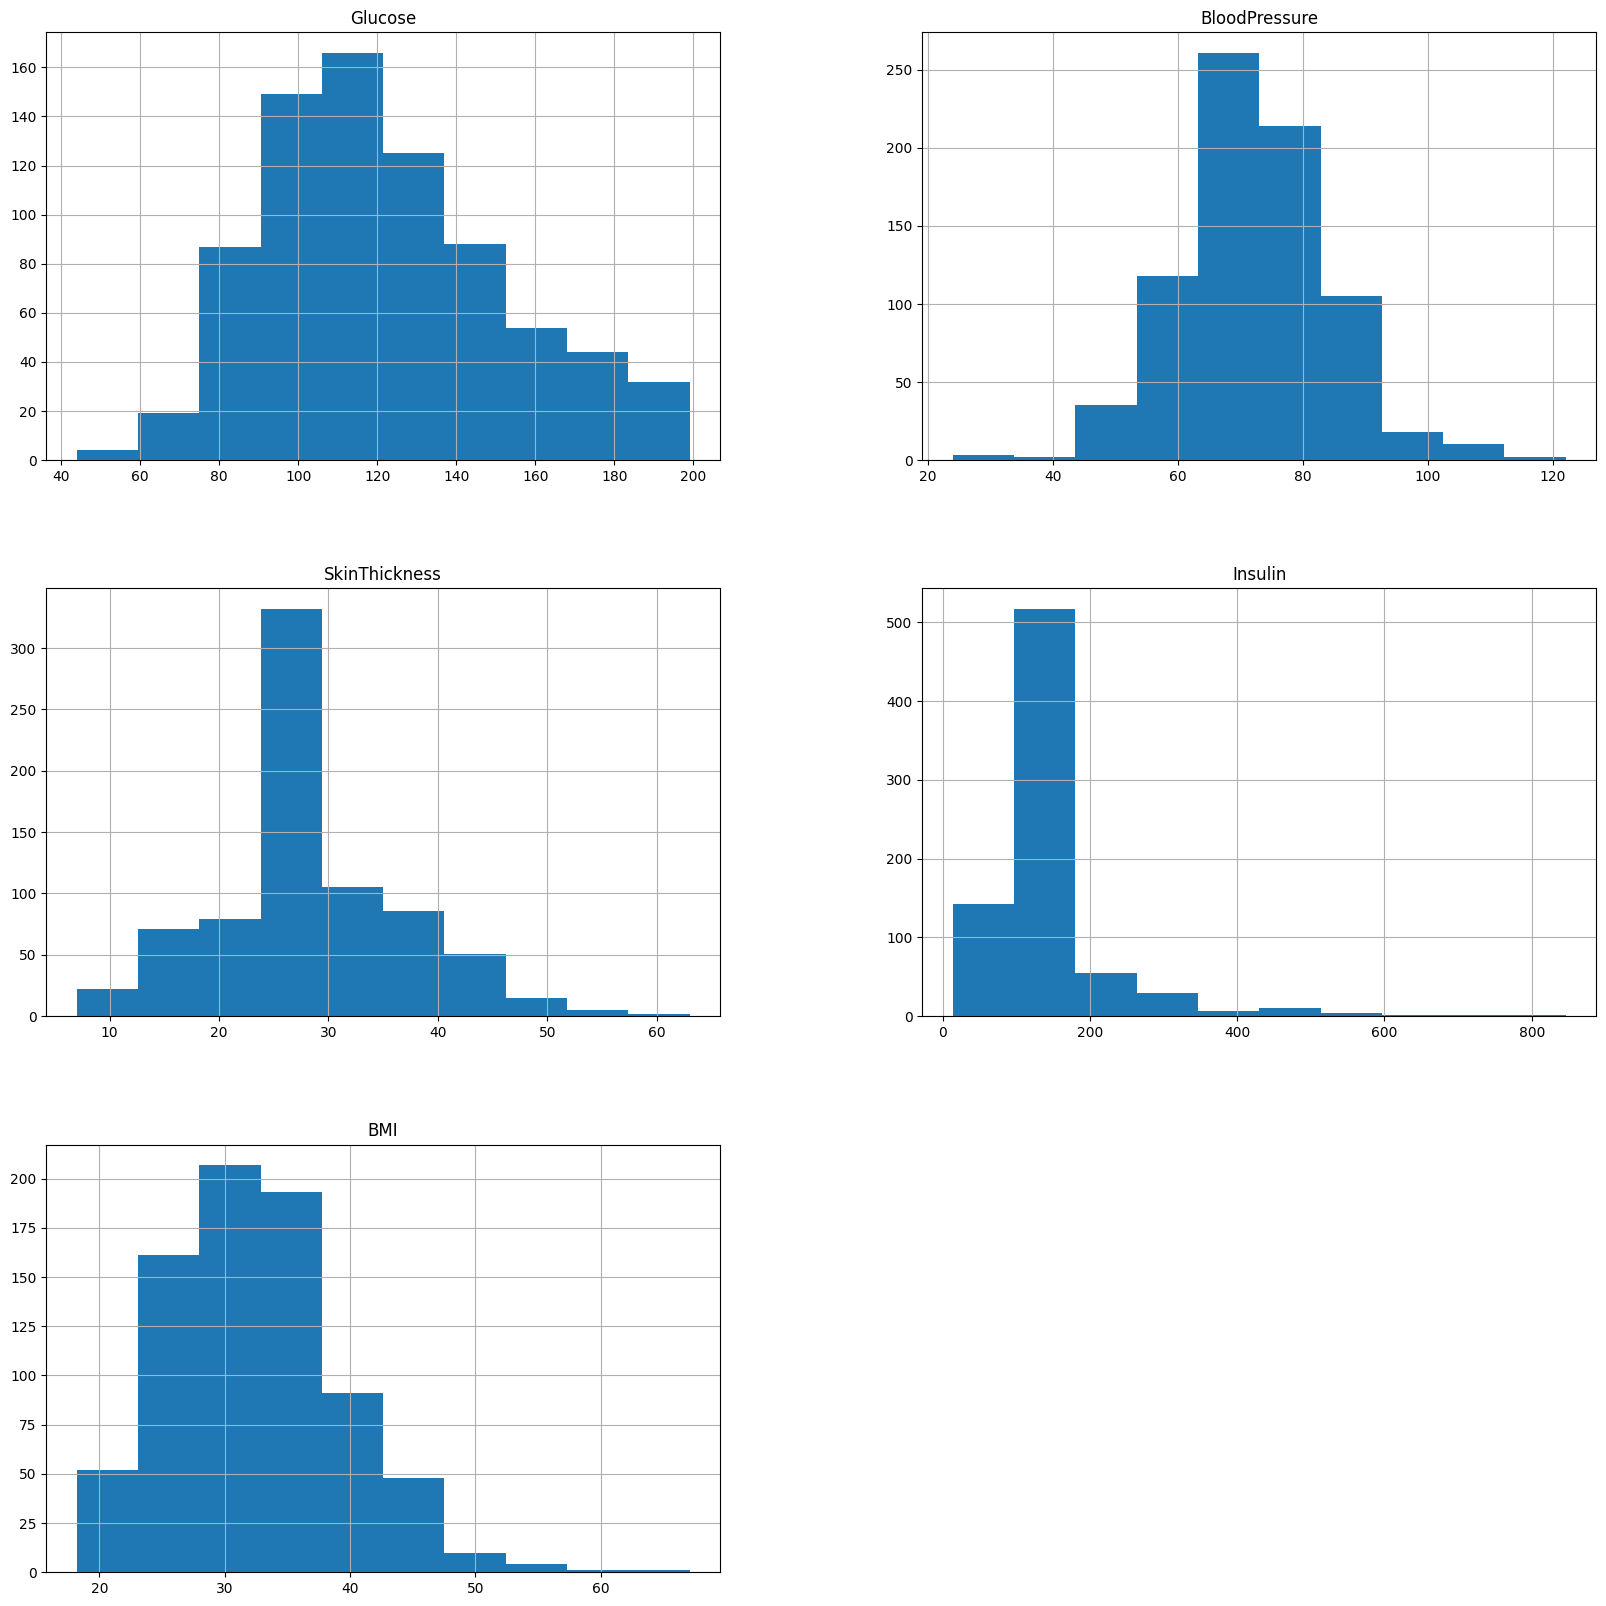

In [204]:

# Impute the missing values with median imputation
diabetes_df_cln['Glucose'] = diabetes_df_cln['Glucose'].fillna(diabetes_df_cln['Glucose'].median())
diabetes_df_cln['BloodPressure'] = diabetes_df_cln['BloodPressure'].fillna(diabetes_df_cln['BloodPressure'].median())
diabetes_df_cln['SkinThickness'] = diabetes_df_cln['SkinThickness'].fillna(diabetes_df_cln['SkinThickness'].median())
diabetes_df_cln['Insulin'] = diabetes_df_cln['Insulin'].fillna(diabetes_df_cln['Insulin'].median())
diabetes_df_cln['BMI'] = diabetes_df_cln['BMI'].fillna(diabetes_df_cln['BMI'].median())

print(diabetes_df_cln.isnull().sum())

# Histogram just for imputed values
imputed_columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
diabetes_df_cln[imputed_columns].hist(figsize=(20, 20))

In [208]:
# Scaling
sc_X_i = StandardScaler()
X_i = pd.DataFrame(sc_X_i.fit_transform(diabetes_df_cln.drop(["Outcome"], axis=1)),
                   columns=['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 
                            'BMI', 'DiabetesPedigreeFunction', 'Age'])

# Train test split
y_i = diabetes_df_cln.Outcome
X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(X_i, diabetes_df_cln['Outcome'], test_size=1/3, 
                                                            random_state=1901448, stratify=y_i)

y_train_i = (y_train_i == 1).astype(float)  # Convert -1 to 0 and keep 1 as 1
y_test_i = (y_test_i == 1).astype(float)

# Convert to torch tensors
X_train_tensor_i = torch.tensor(X_train_i.values, dtype=torch.float32)
y_train_tensor_i = torch.tensor(y_train_i.values, dtype=torch.float32).view(-1, 1)
X_test_tensor_i = torch.tensor(X_test_i.values, dtype=torch.float32)
y_test_tensor_i = torch.tensor(y_test_i.values, dtype=torch.float32).view(-1, 1)

train_dataloader_i = get_data_loader(X_train_tensor_i, y_train_tensor_i)
test_dataloader_i = get_data_loader(X_test_tensor_i, y_test_tensor_i)

# Split train and validation set
X_train_split_i, X_val_split_i, y_train_split_i, y_val_split_i = train_test_split(X_train_tensor_i, y_train_tensor_i, 
                                                                                  test_size=1/5, random_state=1901448)
val_dataloader_i = get_data_loader(X_val_split_i, y_val_split_i)


In [209]:
# Train model

# Model, loss function and optimizer
input_dim = X_train_i.shape[1]
model_i = SingleLayerPerceptron(input_dim)
criterion_i = nn.BCELoss() # Binary Cross Entropy Loss function because our output is binary
optimizer_i = optim.SGD(model_i.parameters(), lr=0.01) # Stochastic Gradient Descent with learning rate 0.01

num_epochs_i = 50
set_seed(1901448)

model_i, train_losses_i, val_losses_i, train_accuracies_i, val_accuracies_i = train_model(
    model_i, train_dataloader_i, val_dataloader_i, num_epochs_i, criterion_i, optimizer_i
)

Epoch 1/50, Train Loss: 0.7263, Val Loss: 0.7122, Train Acc: 53.32%, Val Acc: 57.28%
Epoch 2/50, Train Loss: 0.6989, Val Loss: 0.6809, Train Acc: 58.98%, Val Acc: 60.19%
Epoch 3/50, Train Loss: 0.6756, Val Loss: 0.6649, Train Acc: 61.91%, Val Acc: 62.14%
Epoch 4/50, Train Loss: 0.6553, Val Loss: 0.6280, Train Acc: 63.67%, Val Acc: 69.90%
Epoch 5/50, Train Loss: 0.6381, Val Loss: 0.6140, Train Acc: 65.82%, Val Acc: 70.87%
Epoch 6/50, Train Loss: 0.6232, Val Loss: 0.6099, Train Acc: 66.60%, Val Acc: 70.87%
Epoch 7/50, Train Loss: 0.6103, Val Loss: 0.5808, Train Acc: 67.97%, Val Acc: 72.82%
Epoch 8/50, Train Loss: 0.5990, Val Loss: 0.5684, Train Acc: 69.73%, Val Acc: 75.73%
Epoch 9/50, Train Loss: 0.5892, Val Loss: 0.5526, Train Acc: 70.90%, Val Acc: 75.73%
Epoch 10/50, Train Loss: 0.5804, Val Loss: 0.5257, Train Acc: 70.51%, Val Acc: 76.70%
Epoch 11/50, Train Loss: 0.5727, Val Loss: 0.5454, Train Acc: 71.88%, Val Acc: 78.64%
Epoch 12/50, Train Loss: 0.5658, Val Loss: 0.5310, Train Acc: 7

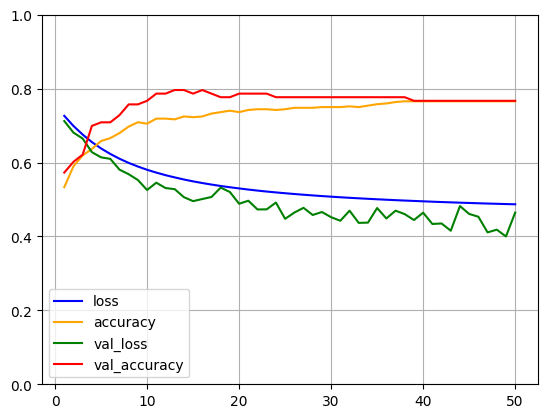

In [213]:
train_accuracies_rescaled_i = [acc / 100 for acc in train_accuracies_i]
val_accuracies_rescaled_i = [acc / 100 for acc in val_accuracies_i]

# Plot learning curves
plt.plot(range(1, num_epochs_i + 1), train_losses_i, label='loss', color='blue')
plt.plot(range(1, num_epochs_i + 1), train_accuracies_rescaled_i, label='accuracy', color='orange')
plt.plot(range(1, num_epochs_i + 1), val_losses_i, label='val_loss', color='green')
plt.plot(range(1, num_epochs_i + 1), val_accuracies_rescaled_i, label='val_accuracy', color='red')
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.legend()
plt.show()

Accuracy: 75.39%
Test Loss: 0.4824


<Axes: >

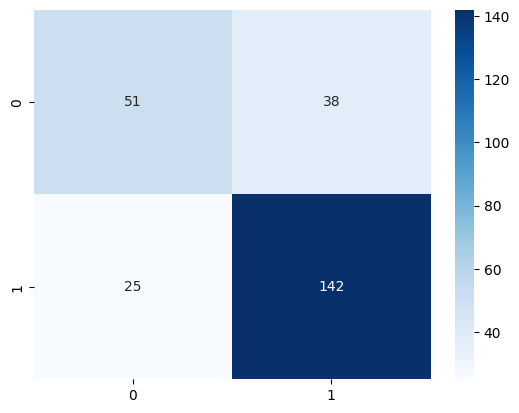

In [211]:
# Evaluation
# Evaluate the model on the test set
accuracy_i, test_loss_i, cm_i = evaluate_model(model_i, test_dataloader_i, criterion_i)
print(f'Accuracy: {accuracy_i:.2f}%')
print(f'Test Loss: {test_loss_i:.4f}')

# Show confusion matrix
sns.heatmap(cm_i, annot=True, fmt='d', cmap='Blues')

# Hyperparameter tuning

The key hyperparameters to tune are:

* Learning rate (`lr`)
* Batch size
* Number of epochs
* Optimizer type (`Adam`, `SGD`)

In [214]:
# Hyperparameter values to try
learning_rates = [0.01, 0.001, 0.0001]
batch_sizes = [16, 32, 64]
epoch_nums = [50, 100]
optimizers = ['adam', 'sgd']

def get_optimizer(optimizer_type, model, lr):
    if optimizer_type == 'adam':
        return optim.Adam(model.parameters(), lr=lr)
    elif optimizer_type == 'sgd':
        return optim.SGD(model.parameters(), lr=lr)

In [216]:
# Track the best model and accuracy
best_accuracy = 0
best_params = {}
history = []

# Loop through different hyperparameter combinations
for lr in learning_rates:
    for batch_size in batch_sizes:
        for num_epochs in epoch_nums:
            for opt in optimizers:
                set_seed(1901448)
                
                # Print current combination of hyperparameters
                print(f'Testing: lr={lr}, batch_size={batch_size}, epochs={num_epochs}, optimizer={opt}')
                
                # Prepare DataLoader
                train_loader = get_data_loader(X_train_tensor, y_train_tensor, batch_size)
                
                # Initialize model and optimizer
                model = SingleLayerPerceptron(X_train.shape[1])
                optimizer = get_optimizer(opt, model, lr)

                # Train the model
                model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
                    model, train_loader, val_dataloader, num_epochs, criterion, optimizer
                )

                # Evaluate the model
                accuracy, test_loss, cm = evaluate_model(model, test_dataloader, criterion)

                # Track history
                history.append({
                    'learning_rate': lr,
                    'batch_size': batch_size,
                    'num_epochs': num_epochs,
                    'optimizer': opt,
                    'train_losses': train_losses,
                    'val_losses': val_losses,
                    'train_accuracies': train_accuracies,
                    'val_accuracies': val_accuracies,
                    'test_accuracy': accuracy,
                    'test_loss': test_loss,
                    'confusion_matrix': cm
                })

                # Check if this is the best model
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_params = {
                        'learning_rate': lr,
                        'batch_size': batch_size,
                        'num_epochs': num_epochs,
                        'optimizer': opt
                    }

                print(f'Accuracy: {accuracy:.2f}%')

# Print the best hyperparameter combination
print(f'Best accuracy: {best_accuracy:.2f}%')
print(f'Best hyperparameters: {best_params}')


Testing: lr=0.01, batch_size=16, epochs=50, optimizer=adam
Epoch 1/50, Train Loss: 0.6644, Val Loss: 0.5748, Train Acc: 61.91%, Val Acc: 72.82%
Epoch 2/50, Train Loss: 0.5879, Val Loss: 0.5512, Train Acc: 72.27%, Val Acc: 75.73%
Epoch 3/50, Train Loss: 0.5490, Val Loss: 0.5003, Train Acc: 73.63%, Val Acc: 77.67%
Epoch 4/50, Train Loss: 0.5234, Val Loss: 0.4812, Train Acc: 75.00%, Val Acc: 77.67%
Epoch 5/50, Train Loss: 0.5096, Val Loss: 0.4449, Train Acc: 75.78%, Val Acc: 79.61%
Epoch 6/50, Train Loss: 0.5001, Val Loss: 0.4523, Train Acc: 76.37%, Val Acc: 79.61%
Epoch 7/50, Train Loss: 0.4930, Val Loss: 0.4553, Train Acc: 76.76%, Val Acc: 79.61%
Epoch 8/50, Train Loss: 0.4885, Val Loss: 0.4505, Train Acc: 76.95%, Val Acc: 78.64%
Epoch 9/50, Train Loss: 0.4847, Val Loss: 0.4299, Train Acc: 77.34%, Val Acc: 77.67%
Epoch 10/50, Train Loss: 0.4823, Val Loss: 0.4374, Train Acc: 77.34%, Val Acc: 77.67%
Epoch 11/50, Train Loss: 0.4802, Val Loss: 0.4473, Train Acc: 77.34%, Val Acc: 77.67%
Epoc

In [117]:
# Create a DataFrame to store the hyperparameter tuning results
results_df = pd.DataFrame(history)

# Select relevant columns to display
results_df = results_df[['learning_rate', 'batch_size', 'num_epochs', 'optimizer', 'test_accuracy', 'test_loss']]

# Print the DataFrame
print(results_df.sort_values(by='test_accuracy', ascending=False))

    learning_rate  batch_size  num_epochs optimizer  test_accuracy  test_loss
3          0.0100          16         100       sgd      79.687500   0.474102
7          0.0100          32         100       sgd      79.687500   0.474102
11         0.0100          64         100       sgd      79.687500   0.474102
10         0.0100          64         100      adam      79.296875   0.471326
2          0.0100          16         100      adam      79.296875   0.471326
6          0.0100          32         100      adam      79.296875   0.471326
0          0.0100          16          50      adam      78.906250   0.472042
22         0.0010          64         100      adam      78.906250   0.478523
14         0.0010          16         100      adam      78.906250   0.478523
18         0.0010          32         100      adam      78.906250   0.478523
8          0.0100          64          50      adam      78.906250   0.472042
4          0.0100          32          50      adam      78.9062

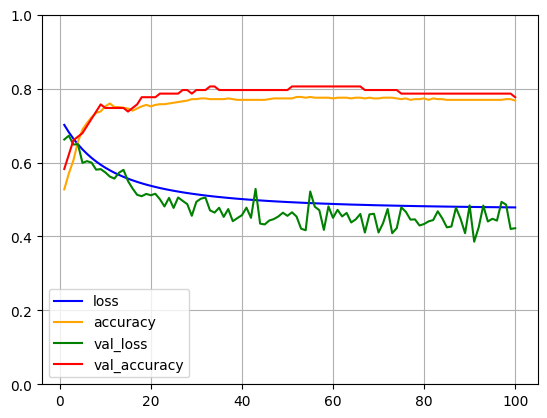

In [219]:
# Collect the history of the best model
best_model_history = [row for row in history if row['learning_rate'] == best_params['learning_rate'] and
                      row['batch_size'] == best_params['batch_size'] and row['num_epochs'] == best_params['num_epochs'] and
                      row['optimizer'] == best_params['optimizer']][0]

# Plot learning curves
train_accuracies_rescaled_best = [acc / 100 for acc in best_model_history['train_accuracies']]
val_accuracies_rescaled_best = [acc / 100 for acc in best_model_history['val_accuracies']]

plt.plot(range(1, best_model_history['num_epochs'] + 1), best_model_history['train_losses'], label='loss', color='blue')
plt.plot(range(1, best_model_history['num_epochs'] + 1), train_accuracies_rescaled_best, label='accuracy', color='orange')
plt.plot(range(1, best_model_history['num_epochs'] + 1), best_model_history['val_losses'], label='val_loss', color='green')
plt.plot(range(1, best_model_history['num_epochs'] + 1), val_accuracies_rescaled_best, label='val_accuracy', color='red')
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.legend()
plt.show()



<Axes: >

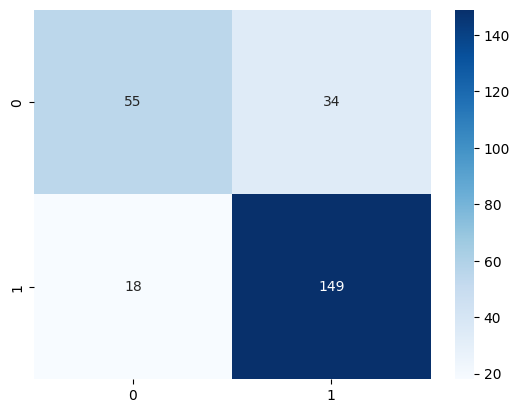

In [220]:
# Plot confusion matrix
sns.heatmap(best_model_history['confusion_matrix'], annot=True, fmt='d', cmap='Blues')